# E-Cell Kaizen Challenge 2020

<img src="https://miro.medium.com/max/500/1*kzso1Ojfc8c0moD2bIs_wQ.jpeg" height=150/>
<img src="https://ecell.iiit.ac.in/assets/imgs/ecell-logo.png" height=150/>
<img src="https://i.imgur.com/e57rpKz.png" height=150/>


This notebook is a solution to the **Optimization Challenge in the E-Cell Kaizen**. This notebook is an introduction to using **Gradient Descent to optimize inputs**.

Since we have a Convex Optimization problem (Essentially a parabola in n-dimentions), we are hopeful that the Gradient descent algorithm will give us a good result.

Solution Author: 
* [Animesh Sinha](http://researchweb.iiit.ac.in/~animesh.sinha) (<animesh.sinha@research.iiit.ac.in>)

Problem Authors: 
* [Garuang Tandon](http://web.iiit.ac.in/~gaurang.tandon) (<gaurang.tandon@students.iiit.ac.in>)
* [Kanish Anand](http://web.iiit.ac.in/~kanish.anand) (<kanish.anand@students.iiit.ac.in>)
* [Arpan Dasgupta](http://researchweb.iiit.ac.in/~arpan.dasgupta) (<arpan.dasgupta@research.iiit.ac.in>)
* [Nikhil Chandak](http://researchweb.iiit.ac.in/~nikhil.chandak) (<nikhil.chandak@research.iiit.ac.in>)
* [Shashwat Goel](http://researchweb.iiit.ac.in/~shashwat.goel) (<shashwat.goel@research.iiit.ac.in>)
* [Yoogottam Khandelwal](http://web.iiit.ac.in/~yoogottam.khandelwal) (<yoogottam.khandelwal@students.iiit.ac.in>)


# Setting up the Data and Packages

## Importing Packages

Let's start by importing all the standard packages we will need for manipulating and plotting the data, setup the styles for it.

We also import PyTorch which we will use for performing Gradient Descent.

If you are running this on your local machine, please run:
`python -m pip install numpy matplotlib seaborn pandas torch tqdm`

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import sklearn
import tensorflow as tf
import tqdm

import os
import math
import re

plt.style.use('ggplot')
DEVICE = 'cpu'

We are connecting our Google Drive to get the input files. Please delete the first 2 lines if you are using a local file. Change the PROJECT_DIR to the directory where your files are. You can change the file name here and try this our for all the different files in the input set.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
PROJECT_DIR = '/content/gdrive/My Drive/Scratch Space/ecell-contest'
FILE_NAME = 'ecell_input_random_2'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Reading in the Data

1000
tensor([8356., 8365., 7648., 7678., 7773., 7642., 7821., 8365., 7961., 8193.,
        8346., 7845., 7921., 7857., 8409., 8039., 7700., 8458., 7981., 7921.,
        8168., 7744., 8445., 8166., 7628., 8256., 7524., 7807., 8172., 7503.,
        7821., 7534., 7825., 7750., 8318., 7750., 8114., 7663., 8485., 8154.,
        8068., 8277., 8390., 7919., 7938., 8332., 8154., 8160., 7737., 7974.,
        7770., 8421., 7790., 7632., 8104., 7576., 8076., 7644., 8127., 7907.,
        8175., 7703., 7674., 8187., 7963., 7656., 8457., 8498., 8352., 8020.,
        7796., 7506., 7639., 8217., 7594., 7711., 8242., 7668., 8159., 7827.,
        8207., 7735., 7750., 8099., 7552., 8437., 7904., 8410., 7975., 8191.,
        7630., 7909., 7506., 7978., 7623., 7977., 7859., 7682., 8135., 7591.,
        8089., 7916., 7851., 8417., 7523., 7966., 7699., 8216., 7642., 7751.,
        7569., 7594., 8320., 8228., 7937., 7713., 7726., 7899., 7835., 8284.,
        7803., 8393., 8315., 7587., 7682., 7722., 8256., 78

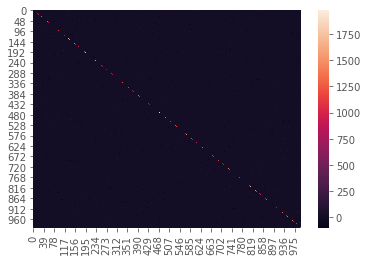

In [3]:
class Graph:

    def __init__(self, path):
        with open(os.path.join(PROJECT_DIR, path)) as f:
            data = f.readlines()
            self.n = int(data[0].strip())
            self.lim, self.val = zip(*list(map(
                lambda x: list(map(int, x.strip().split())), data[1:self.n+1])))
            self.var = np.array(list(map(
                lambda x: list(map(int, x.strip().split(' '))), 
                data[self.n + 1: 2 * self.n + 1])))
            self.val = torch.tensor(self.val).to(DEVICE).float()
            self.lim = torch.tensor(self.lim).to(DEVICE).float()
            self.var = torch.tensor(self.var).to(DEVICE).float()


    def __str__(self):
        return '\n'.join([str(self.n), str(self.val),
                          str(self.lim), str(self.var)])
        
    def heatmap(self):
        sns.heatmap(self.var.detach().cpu().numpy())
        plt.show()

g = Graph('%s.txt'%(FILE_NAME))
print(g)
g.heatmap()

# The Gradient Descent

## Defining the scorers

This is the loss function, which is the negative of the score function as in the problem statement:
$$ \text{LOSS} = \sum_{i = 1}^{n} \sum_{j = i}^{m} \alpha_{i} \alpha_{j}\; Cov[i, j] - \sum_{i = 1}^{n} \alpha_i\; Val[i]  $$

In [4]:
def loss_fn(alpha, g):
    n = alpha.shape[0]
    sc_val = torch.mul(alpha, g.val)
    sc_cov = torch.mul(g.var, torch.ger(alpha, alpha))
    var_sum = torch.sum(torch.mul(sc_cov, torch.eye(n)))
    total_sum = torch.sum(sc_cov)
    cov_sum = (total_sum - var_sum) / 2
    loss = cov_sum + var_sum - torch.sum(sc_val)
    return loss


alpha = torch.tensor(torch.mul(g.lim, torch.randn(g.n)), requires_grad=True).to(DEVICE).float()
for i in range(g.n):
    alpha.clamp(0, g.lim[i])

loss_fn(alpha.detach(), g)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':


tensor(9348755.)

## The Training Loop

This is the standard PyTorch Traning loop.

The only difference is that there is a clamp on the values in the tensor, so that we are still in the limits as posed by the problem.

The optimizer is given the alpha vector to optimize, the gradient descent is on the input and not on the parameters of the model. (Since there is no model, we only the need the optimal input that minimizes the loss function.)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
100%|██████████| 1000/1000 [00:22<00:00, 45.09it/s, score=2.71e+6]


tensor([2.0000, 0.0100, 0.0100, 0.8981, 0.0100, 0.0100, 0.7235, 0.0100, 0.1011,
        0.2049, 0.0407, 0.0183, 0.1904, 0.0100, 0.9025, 0.0100, 0.0100, 1.0000,
        0.0100, 0.0557, 0.0100, 0.0100, 0.1353, 0.1975, 0.5697, 0.0100, 0.4543,
        0.0133, 1.0000, 0.1626, 0.8469, 0.0100, 0.0100, 0.5911, 0.0100, 1.0000,
        1.7931, 0.0100, 0.0100, 1.9251, 0.0100, 0.4177, 0.2974, 0.0100, 0.0100,
        0.2508, 0.0100, 0.2395, 0.0100, 0.9823, 1.0111, 0.0100, 0.4263, 0.0100,
        1.6965, 0.0100, 1.0095, 1.0000, 0.1772, 0.0100, 0.7728, 1.2993, 0.6982,
        0.0100, 0.0100, 0.0100, 0.3874, 0.8345, 0.0100, 0.1187, 0.0100, 0.5941,
        1.5109, 1.2124, 3.0000, 1.0000, 0.1253, 0.1488, 1.0000, 0.0100, 0.0225,
        0.0100, 0.0100, 0.2935, 0.0099, 0.5305, 1.0000, 0.2825, 1.8645, 1.0000,
        0.0100, 0.0100, 0.0100, 2.6476, 0.0100, 0.2325, 0.0100, 0.0100, 0.6050,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.1674, 0.0163, 0.0100, 0.3434,
        0.0100, 1.3382, 0.5517, 0.0100, 

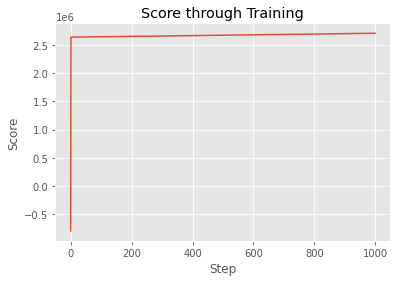

In [5]:
alpha = torch.tensor(torch.randn(g.n), requires_grad=True).to(DEVICE).float()
for i in range(g.n):
    alpha.clamp(0, g.lim[i])

opt = torch.optim.Adam([alpha], lr=1e-5) # Try out Stochastic Gradient Descent too 

score_history = []
with tqdm.trange(1000) as tq: # Feel Free to increase the number of epochs here
    for i in tq:
        loss = loss_fn(alpha, g)
        tq.set_postfix(score=-loss.item())
        score_history.append(-loss.item())
        opt.zero_grad()
        loss.backward()
        opt.step()
        with torch.no_grad():
            for i in range(g.n):
                alpha[i] = torch.clamp(alpha[i], 0, g.lim[i])

print(alpha.clone().detach())
plt.plot(score_history)
plt.title('Score through Training')
plt.xlabel('Step')
plt.ylabel('Score')
plt.show()

# The Final Outputs

We need to round off and start getting the scores on the tasks.

## Score function

This is the officially provided score function, does the same things as the loss function but on regular numpy arrays and in the opposite sense (positive score is negative loss).

In [6]:
def score(vals, cov, betas):
    n = cov.shape[0]
    sc = np.sum(np.multiply(betas, vals))

    res = np.ones((n, n))
    res1 = np.multiply(res, betas) # row-copies of beta
    res2 = res1.T
    res = np.multiply(res1, res2)
    res = np.multiply(res, cov)

    var_sum = np.sum(np.multiply(res, np.eye(n)))
    total_sum = np.sum(res)
    cov_sum = (total_sum - var_sum) // 2
    sc -= cov_sum + var_sum
    return sc

We detach all our torch tensors and get them on the CPU. (in case you changed the device to a GPU, and you are welcome to do that if you have one).

And we finally output the loss function value.

In [7]:
val = g.val.detach().cpu().numpy()
var = g.var.detach().cpu().numpy()
ans = alpha.detach().cpu().numpy()

print('Answer:\n', score(val, var, np.round(ans)), np.round(ans))

Answer:
 2495417.0 [2. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 2. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 2. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 2. 1. 3. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 2. 1. 0. 0. 0. 3. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 2. 1. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 2. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1.
 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 1. 0. 2. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 2. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 2. 0. 0. 0. 2. 1. 0. 0. 0. 0

And yay, the Gradient Descent gets reasonably good scores on many of the datasets, atleast the ones that are randomly generated. 😄